In [28]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy import control as ctrl
import random

In [29]:
PATH = './AMAZON_FASHION.json.gz'
PATH_meta = './meta_AMAZON_FASHION.json.gz'

## MODULO 1
### Lector de datasets

In [30]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [31]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [32]:
df_meta.shape

(186637, 16)

In [33]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [113]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 17)

Text(0, 0.5, 'Count')

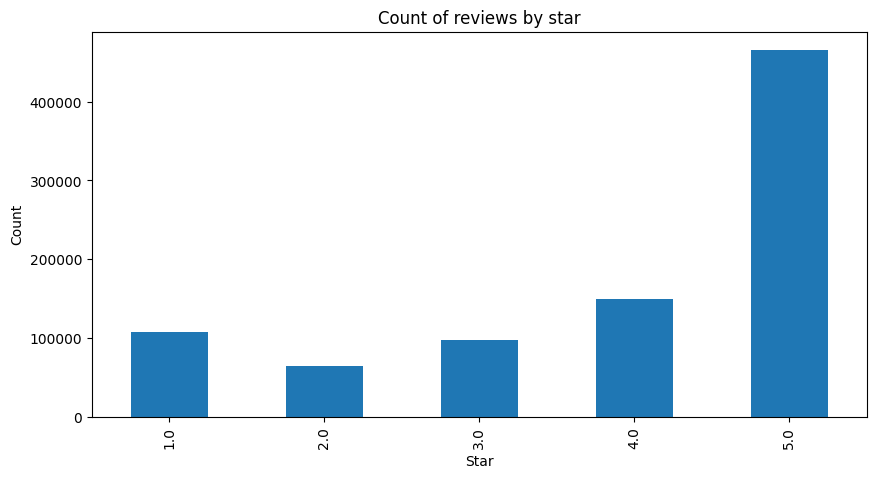

In [114]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")

notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [115]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## MODULO 2
### Rating Score
calculamos el overall mean

In [116]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


agregamos la columnas id al dataframe df_meta

In [117]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos la muestra para facilitar el procesamiento 

In [118]:
CANTIDAD = 10000

In [119]:
df_meta_cortado = df_meta.head(CANTIDAD)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [120]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_meta_cortadoFrame 'df_meta_cortado'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


C:\Users\arase\AppData\Local\Temp\ipykernel_8648\2222405249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_cortado['combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


La matriz vecs contiene las puntuaciones TF-IDF ( Frecuencia de Término - Frecuencia Inversa de Documento) para cada palabra en cada documento. Las puntuaciones TF-IDF representan la importancia de una palabra para un documento en la colección.

In [121]:

vec = TfidfVectorizer()
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(10000, 22929)

## Modulo 3
### Similarity Score

Esto significa que tienes 10000 documentos (las filas del DataFrame df_meta_cortado) y 22929 palabras únicas en todos los documentos (las características).

calcular la similitud del coseno entre cada par de vectores en vecs

Su valor varía de -1 (vectores completamente opuestos) a 1 (vectores idénticos), con 0 indicando ortogonalidad (vectores perpendiculares).

In [122]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.00388052, 0.039671  , ..., 0.00938346, 0.00938346,
        0.00179705],
       [0.00388052, 1.        , 0.        , ..., 0.        , 0.        ,
        0.00467325],
       [0.039671  , 0.        , 1.        , ..., 0.1177269 , 0.1177269 ,
        0.        ],
       ...,
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00179705, 0.00467325, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [123]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    # scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

### Seleccionamos 4 productos aleatorios

In [124]:
# Inicializa listas vacías para almacenar los resultados
asins_resultados = []
similaridad_score_resultados = []

# Lista de asins únicos del DataFrame df_meta_cortado
asins_unicos = df_meta_cortado['asin'].unique()

# Realiza 4 recomendaciones con valores aleatorios
for i in range(4):
    random_asin = random.choice(asins_unicos)
    print(random_asin)
    asins, similaridad_score = recommend(random_asin)
    # Agrega los resultados a las listas
    asins_resultados.append(asins)
    similaridad_score_resultados.append(similaridad_score)


B002OSEE2G
['B002OSEEGW', 'B003DTRVA2', 'B001MSYSYS', 'B000RAN064', 'B000RAL29Q', 'B0051PKO4Q', 'B003DTQ3GK', 'B003K378W2', 'B002OSE840', 'B000RAONOW', 'B004D588FW', 'B000RAQBNS', 'B00558EZ3A', 'B0051IZET8', 'B000W9GEMC', 'B00007G9CV', 'B000RAU0SA', 'B001BFLPK2', 'B000RAOVRQ', 'B0037G8KLK', 'B000EHU1BW', 'B000ZKKQ7M', 'B001YK7JDG', 'B0020LQLQY', 'B000ZKF9GU', 'B003OILAU4', 'B001L4ZYVE', 'B000BZ4G6S', 'B000FXXTAK', 'B004ZFIG1G', 'B0006A1OM2', 'B002CFKRFY', 'B002OSJU6Q', 'B004DQ6QRS', 'B0000ES6QK', 'B000RASC58', 'B0000ES3LP', 'B0054JV9IO', 'B002VDTYA6', 'B003K33DS0', 'B0031D53R8', 'B003DIP31M', 'B004Q5QCKC', 'B0031D78NU', 'B000QVB7QE', 'B002OSAJW0', 'B000RAJ7X4', 'B001DC5SHO', 'B000IBZJ7A', 'B001M5P8U4', 'B000KQNZ9C', 'B0008MF9II', 'B001L51XKE', 'B0008Q5KZQ', 'B000K6TG8G', 'B000HCR3WE', 'B0012QOGS8', 'B000IBXIT6', 'B002WTWG7W', 'B000IBUMM2', 'B004XO3Q8M', 'B000PTHF8Q', 'B001YKGIWY', 'B0002HBBAO', 'B000RAN4PQ', 'B004Z9F264', 'B000M48FIS', 'B000M4BOE0', 'B000M4DF0G', 'B000M49WSU', 'B0056TQ

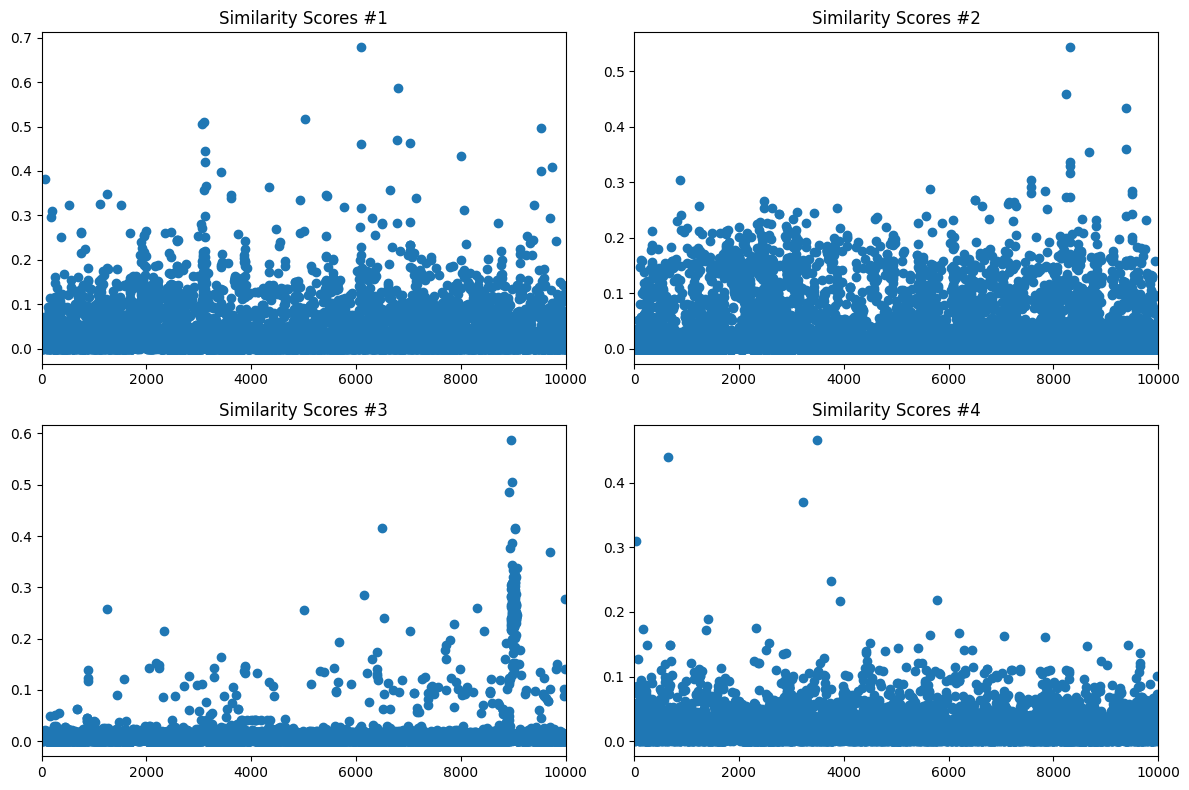

In [125]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterar a través de los 4 resultados y graficarlos en subplots separados
for i in range(4):
    scores_df = pd.DataFrame(similaridad_score_resultados[i], columns=['ItemID', 'Score'])
    ax = axs[i // 2, i % 2]  # Seleccionar el subplot adecuado
    ax.scatter(scores_df['ItemID'], scores_df['Score'])
    ax.set_title(f'Similarity Scores #{i+1}')
    ax.set_xlim(0, 10000)

plt.tight_layout()
plt.show()


In [133]:
# Inicializa listas vacías para almacenar los resultados
final_results = []
# Itera a través de los 4 conjuntos de resultados
for producto in range(4):
    top_scores_product = [similarity_score[1] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_item_ids_product = [similarity_score[0] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_asin_product = asins_resultados[producto][:CANTIDAD]

    # Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
    data = list(zip(top_asin_product, top_scores_product, top_item_ids_product))

    # Crear un DataFrame a partir de los datos combinados
    df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

    # Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
    final_result = pd.merge(df_result, overall_mean, on='asin')
    print(final_result)
    final_results.append(final_result)



            asin     Score    Id  overall
0     B002OSEEGW  0.678203  6086      3.0
1     B003DTRVA2  0.587677  6792      5.0
2     B001MSYSYS  0.516112  5023      4.5
3     B000RAN064  0.509663  3091      3.0
4     B000RAL29Q  0.504931  3064      5.0
...          ...       ...   ...      ...
9994  B00591PC62  0.000000  9994      3.8
9995  B00591YLEG  0.000000  9995      5.0
9996  B00591XGD8  0.000000  9996      5.0
9997  B00591VVDA  0.000000  9997      3.0
9998  B00591YFH4  0.000000  9998      4.0

[9999 rows x 4 columns]
            asin     Score    Id   overall
0     B004IX6BHG  0.542910  8320  4.000000
1     B004HJUNIY  0.458882  8236  4.000000
2     B004ZC4F96  0.433253  9385  5.000000
3     B004ZC4CB2  0.359242  9390  3.000000
4     B004P59732  0.354358  8682  5.000000
...          ...       ...   ...       ...
9984  B0058Z8MJS  0.000000  9989  5.000000
9985  B00590S7D8  0.000000  9990  5.000000
9986  B005914EJ8  0.000000  9991  2.000000
9987  B00591E4MK  0.000000  9992  4.77777

## MODULO 4
### Sistema de inferencia difuso

In [134]:
# Definimos las variables de entrada y salida para el sistema de control difuso
overall = ctrl.Antecedent(np.arange(1, 6, 0.1), 'overall')  # Calificación general
similaridad = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'similaridad')  # Similaridad con otros elementos
recomendacion = ctrl.Consequent(np.arange(0, 2, 0.1), 'recomendacion')  # Recomendación resultante

# Definimos los trapecios para las variables de entrada y salida
overall['excelente'] = fuzz.trapmf(overall.universe, [4.1, 5, 5, 5]) # si el valor es [4.1 o 5], entonces es excelente
overall['bueno'] = fuzz.trapmf(overall.universe, [3.1, 4, 4, 4.1]) # si el valor es [3.1 o 4.1), entonces es bueno
overall['normal'] = fuzz.trapmf(overall.universe, [2.1, 3, 3, 3.1]) # si el valor es [2.1 o 3.1), entonces es normal
overall['pesimo'] = fuzz.trapmf(overall.universe, [0.99, 2, 2, 2.1]) # si el valor es (0.99 o 2.1), entonces es pesimo

similaridad['muy_similar'] = fuzz.trapmf(similaridad.universe, [0.7, 1, 1, 1]) # si el valor es [0.7 o 1], entonces es muy similar
similaridad['similar'] = fuzz.trapmf(similaridad.universe, [0.4, 0.7, 0.7, 0.7]) # si el valor es [0.4 o 0.7), entonces es similar
similaridad['poco_similar'] = fuzz.trapmf(similaridad.universe, [0.2, 0.4, 0.4, 0.4]) # si el valor es [0.2 o 0.4), entonces es poco similar
similaridad['no_similar'] = fuzz.trapmf(similaridad.universe, [-1, 0, 0, 0.2])  # si el valor es [-1 o 0.2), entonces es no similar


recomendacion['muy_recomendado'] = fuzz.trapmf(recomendacion.universe, [1.1, 2, 2, 2]) # si el valor es [1.1 o 2], entonces es muy recomendado
recomendacion['recomendado'] = fuzz.trapmf(recomendacion.universe, [0.1, 1, 1, 1.1]) # si el valor es [0.1 o 1.1), entonces es recomendado
recomendacion['no_recomendado'] = fuzz.trapmf(recomendacion.universe, [0, 0, 0, 0.1]) # si el valor es [0 o 0.1), entonces es no recomendado

# regla 1: si la similaridad es no similar y el overall es excelente, bueno, normal o pesimo, entonces la recomendacion es no recomendado
rule1 = ctrl.Rule(similaridad['no_similar'] & (overall['excelente'] | overall['bueno'] | overall['normal'] | overall['pesimo']), recomendacion['no_recomendado'])
# regla 2: si la similaridad es muy similar, similar, poco similar o no similar y el overall es pesimo, entonces la recomendacion es no recomendado
rule2 = ctrl.Rule(overall['pesimo'] & (similaridad['muy_similar'] | similaridad['similar'] | similaridad['poco_similar'] | similaridad['no_similar']), recomendacion['no_recomendado'])
# regla 3: si la similaridad es muy similar o similar y el overall es excelente o bueno, entonces la recomendacion es muy recomendado
rule3 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['muy_recomendado'])
# regla 4: si la similaridad es muy similar o similar y el overall es normal, entonces la recomendacion es recomendado
rule4 = ctrl.Rule(overall['normal']  & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['recomendado'])
# regla 5: si la similaridad es muy similar o similar y el overall es excelente o bueno y poco similar, entonces la recomendacion es recomendado
rule5 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['poco_similar']), recomendacion['recomendado'])
# regla 6: si la similaridad es poco similar y el overall es normal, entonces la recomendacion es no recomendado
rule6 = ctrl.Rule(overall['normal'] & similaridad['poco_similar'], recomendacion['no_recomendado'])

# Sistema de control y simulación
sistema_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_simulacion = ctrl.ControlSystemSimulation(sistema_control)

testeamos

In [135]:
# Pasar entradas al sistema
sistema_simulacion.input['overall'] = 4  # Ejemplo de calificación
sistema_simulacion.input['similaridad'] = 0.7  # Ejemplo de calificación
sistema_simulacion.compute() # Defuzzificación

# Por el metodo 'centroide'
print(sistema_simulacion.output['recomendacion'])

1.6333333333333335


## MODULO 5
### Defusificador

Defuzzificamos el resultado

In [136]:
def sistema_recomendacion_defuzzificado (recomendacion):
    if recomendacion < 0.1:
        return 'no_recomendado'
    elif recomendacion < 1.1:
        return 'recomendado'
    else:
        return 'muy_recomendado'
    

In [137]:
def sistema_recomendacion( similarity, overall):
    sistema_simulacion.input['overall'] = overall  # Ejemplo de calificación
    sistema_simulacion.input['similaridad'] = similarity # Ejemplo de calificación
    sistema_simulacion.compute() # Defuzzificación
    return (sistema_recomendacion_defuzzificado(sistema_simulacion.output['recomendacion']),sistema_simulacion.output['recomendacion'] )

In [140]:
# Itera a través de los 4 conjuntos de resultados

for i in range(4):
   # Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
    final_results[i]['result'] = final_results[i].apply(lambda row: sistema_recomendacion(row['Score'], row['overall']), axis=1) 
    

# Para mostrar el DataFrame resultante
for i, df_result in enumerate(final_results):
    print(f"Resultados para conjunto {i + 1}:")
    print(final_results[i]['result'])
    print()


Resultados para conjunto 1:
0            (recomendado, 0.7320209063138557)
1        (muy_recomendado, 1.5000446773079963)
2        (muy_recomendado, 1.5790053309548995)
3            (recomendado, 0.6676583414098389)
4        (muy_recomendado, 1.5000446773079963)
                         ...                  
9994    (no_recomendado, 0.034680134680134686)
9995     (no_recomendado, 0.04997070884592774)
9996     (no_recomendado, 0.04997070884592774)
9997     (no_recomendado, 0.03333333333333333)
9998     (no_recomendado, 0.03333333333333333)
Name: result, Length: 9999, dtype: object

Resultados para conjunto 2:
0        (muy_recomendado, 1.5941048610539745)
1            (recomendado, 0.9348994949049978)
2            (recomendado, 0.9999602701628987)
3       (no_recomendado, 0.034483304619553505)
4            (recomendado, 0.5995902838747502)
                         ...                  
9984     (no_recomendado, 0.04997070884592774)
9985     (no_recomendado, 0.04997070884592774)
9986    

In [139]:
# Realizar un join entre final_result y dataset_original utilizando la columna 'ASIN' como clave de unión
resultado_completo = pd.merge(final_result, df_meta_cortado, on='asin')

# Imprimir el resultado completo
resultado_completo


,asin,Score,Id,overall,result,title,brand,feature,rank,date,...,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
0,B000X60GKU,0.466171,3490,4.421053,"(recomendado, 0.9767904338573774)",Watch Storage Case for 10 Watches,Paylak Inc,NaN,"9,369,852inClothing,ShoesJewelry(",TSBOX10KEY-WNT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490,Watch Storage Case for 10 Watches Paylak Inc nan
1,B0007KQOMQ,0.439311,643,4.454545,"(recomendado, 0.8734697414302008)",Watch Box Storage Case For 6 Watches Burlwood ...,"Paylak, Inc.",NaN,"12,024,048inClothing,Shoesamp;Jewelry(",TSAA31-575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,643,Watch Box Storage Case For 6 Watches Burlwood ...
2,B000TK0PG0,0.370857,3216,4.428571,"(recomendado, 0.667581034571326)",Watch Box Storage Case For 6 Burlwood Black La...,Paylak Inc,NaN,"16,181,531inClothing,Shoesamp;Jewelry(",ATSBOXBB6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3216,Watch Box Storage Case For 6 Burlwood Black La...
3,B000073249,0.309889,35,3.500000,"(recomendado, 0.6804232804232805)",Travelon Comfort Grip 3-in-1 Travel Handle,NaN,NaN,NaN,5 star,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,Travelon Comfort Grip 3-in-1 Travel Handle nan...
4,B0012S5SXI,0.247645,3754,1.000000,"(no_recomendado, 0.04975288573633482)",Deluxe Watch Winder For Single Automatic Watch...,"Paylak, Inc.",[Package Dimensions:\n \n10...,"14,986,338inClothing,ShoesJewelry(","Paylak, Inc.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3754,Deluxe Watch Winder For Single Automatic Watch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,B0058OA0P8,0.000000,9928,4.548387,"(no_recomendado, 0.038922107880457246)",Bamboo Full Cushion Hiking/Outdoor Crew Socks ...,Ecosox,"[70% Viscose from Bamboo, 25% Polyester, 4% Ru...","104,963inClothing,ShoesJewelry(",5 star,...,"[, EcoSox Medium Weight/Full Cushion Hiking So...",$10.98 - $11.45,"[B07BLM2CR8, B075D8GXJR, B01B2FXDB4, B079MSBFP...","[B07BLM2CR8, B00FN4UB48, B07CQDDQ3C, B075D8GXJ...","class=""a-normal a-align-center a-spacing-smal...",NaN,NaN,NaN,9928,Bamboo Full Cushion Hiking/Outdoor Crew Socks ...
9995,B0058UZNEA,0.000000,9943,3.785714,"(no_recomendado, 0.03485958485958487)",Step Brothers Sailing Bahamas Turquoise Blue A...,Step Brothers,"[cotton, 100%Cotton, Officially Licensed, Prin...","985,132inClothing,ShoesJewelry(",5 star,...,[This tee is a replica of the tee Brennan (Wil...,$18.95,"[B07CHXYD8B, B07C1TDB24, B0714G56MN, B07GQ1FF3...","[B07CKFHYJT, B07GQ1FF34, B01MQKOD6M, B07BWJGMJ...","class=""a-normal a-align-center a-spacing-smal...",NaN,NaN,NaN,9943,Step Brothers Sailing Bahamas Turquoise Blue A...
9996,B0058VWP3Q,0.000000,9945,5.000000,"(no_recomendado, 0.04997070884592774)",Costa Del Mar Purple and Gold Neoprene Sunglas...,Costa Del Mar,NaN,"14,365,325inClothing,ShoesJewelry(",5 star,...,[Made by Costa Del Mar. This product will reta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9945,Costa Del Mar Purple and Gold Neoprene Sunglas...
9997,B005914EJ8,0.000000,9991,2.000000,"(no_recomendado, 0.03333333333333333)",Crooks & Castles Women's Knit Cropped Hoodie-L...,Crooks & Castles,[Package Dimensions:\n \n11...,"14,629,888inClothing,ShoesJewelry(",5 star5 star (0%),...,[Cropped Hooded Sweatshirt100% Cotton French T...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9991,Crooks & Castles Women's Knit Cropped Hoodie-L...
